<a href="https://colab.research.google.com/github/jayadir/FMML2024_assignments_projects/blob/main/Module_7_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Module 7 Project: Movie Recommendation Engine

`Module Coordinator: Ganesh Chandan`

In this module, we will try to create a Movie Recommendation System using different unsupervised learning techniques.

In [1]:
# dataset download

# !wget https://files.grouplens.org/datasets/movielens/ml-100k.zip
!wget https://files.grouplens.org/datasets/movielens/ml-latest-small.zip
!unzip ml-latest-small.zip

--2025-02-22 12:24:50--  https://files.grouplens.org/datasets/movielens/ml-latest-small.zip
Resolving files.grouplens.org (files.grouplens.org)... 128.101.65.152
Connecting to files.grouplens.org (files.grouplens.org)|128.101.65.152|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 978202 (955K) [application/zip]
Saving to: ‘ml-latest-small.zip’

ml-latest-small.zip 100%[===================>] 955.28K  3.30MB/s    in 0.3s    

2025-02-22 12:24:51 (3.30 MB/s) - ‘ml-latest-small.zip’ saved [978202/978202]

Archive:  ml-latest-small.zip
   creating: ml-latest-small/
  inflating: ml-latest-small/links.csv  
  inflating: ml-latest-small/tags.csv  
  inflating: ml-latest-small/ratings.csv  
  inflating: ml-latest-small/README.txt  
  inflating: ml-latest-small/movies.csv  


## Clustering based recommendation

In [2]:
# Import Libraries
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy.sparse import csr_matrix
from mpl_toolkits.axes_grid1 import make_axes_locatable
from sklearn.cluster import KMeans
from sklearn.metrics import mean_squared_error
import itertools
from sklearn.metrics import silhouette_samples, silhouette_score

In [3]:
# Import the Movies dataset
movies = pd.read_csv('ml-latest-small/movies.csv')
movies.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [4]:
# Import the ratings dataset
ratings = pd.read_csv('ml-latest-small/ratings.csv')
ratings.head()

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


In [5]:
# Print the number of records and the total number of movies
print('The dataset contains: ', len(ratings), ' ratings of ', len(movies), ' movies.')

The dataset contains:  100836  ratings of  9742  movies.


### Romance versus Science Fiction

We will start by considering a subset of users and discovering what are their favourite genre. We will do this by defining a function that will calculate each user’s average rating for all science fiction and romance movies.

In [6]:
# Function to get the genre ratings
def get_genre_ratings(ratings, movies, genres, column_names):
    genre_ratings = pd.DataFrame()
    for genre in genres:
        genre_movies = movies[movies['genres'].str.contains(genre) ]
        avg_genre_votes_per_user = ratings[ratings['movieId'].isin(genre_movies['movieId'])].loc[:, ['userId', 'rating']].groupby(['userId'])['rating'].mean().round(2)

        genre_ratings = pd.concat([genre_ratings, avg_genre_votes_per_user], axis=1)

    genre_ratings.columns = column_names
    return genre_ratings# Calculate the average rating of romance and scifi movies
genre_ratings = get_genre_ratings(ratings, movies, ['Romance', 'Sci-Fi'], ['avg_romance_rating', 'avg_scifi_rating'])
genre_ratings.head()

,avg_romance_rating,avg_scifi_rating
1,4.31,4.22
2,4.50,3.88
3,0.50,4.20
4,3.38,2.83
5,3.09,2.50


In order to have a more delimited subset of people to study, we are going to bias our grouping to only get ratings from those users that like either romance or science fiction movies.

In [7]:
# Function to get the biased dataset
def bias_genre_rating_dataset(genre_ratings, score_limit_1, score_limit_2):
    biased_dataset =    genre_ratings[((genre_ratings['avg_romance_rating'] < score_limit_1 - 0.2) & (genre_ratings['avg_scifi_rating'] > score_limit_2)) | ((genre_ratings['avg_scifi_rating'] < score_limit_1) & (genre_ratings['avg_romance_rating'] > score_limit_2))]
    biased_dataset = pd.concat([biased_dataset[:300], genre_ratings[:2]])
    biased_dataset = pd.DataFrame(biased_dataset.to_records())
    return biased_dataset

# Bias the dataset
biased_dataset = bias_genre_rating_dataset(genre_ratings, 3.2, 2.5)

# Printing the resulting number of records & the head of the dataset
print( "Number of records: ", len(biased_dataset))
biased_dataset.head()

Number of records:  162


,index,avg_romance_rating,avg_scifi_rating
0,3,0.50,4.20
1,4,3.38,2.83
2,5,3.09,2.50
3,7,2.65,3.15
4,9,3.17,3.00


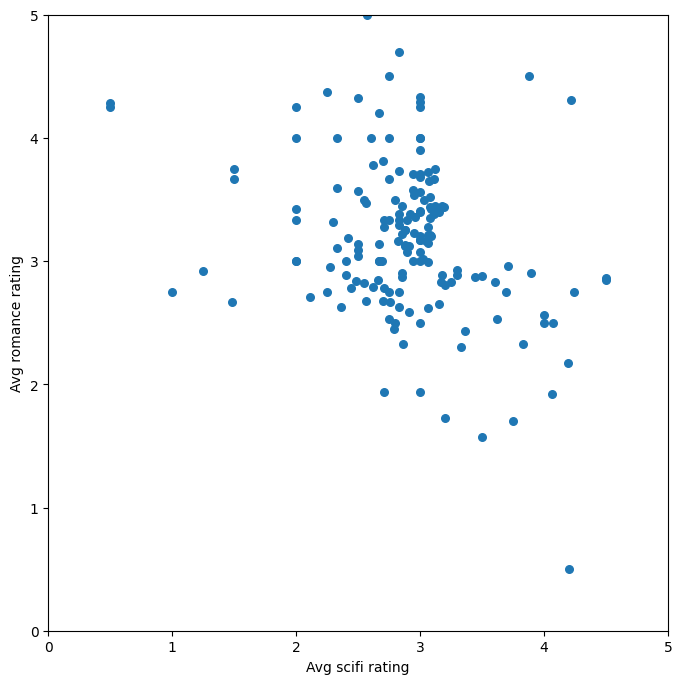

In [8]:
# Defining the scatterplot drawing function
def draw_scatterplot(x_data, x_label, y_data, y_label):
    fig = plt.figure(figsize=(8,8))
    ax = fig.add_subplot(111)
    plt.xlim(0, 5)
    plt.ylim(0, 5)
    ax.set_xlabel(x_label)
    ax.set_ylabel(y_label)
    ax.scatter(x_data, y_data, s=30)

# Plot the scatterplot
draw_scatterplot(biased_dataset['avg_scifi_rating'],'Avg scifi rating', biased_dataset['avg_romance_rating'], 'Avg romance rating')

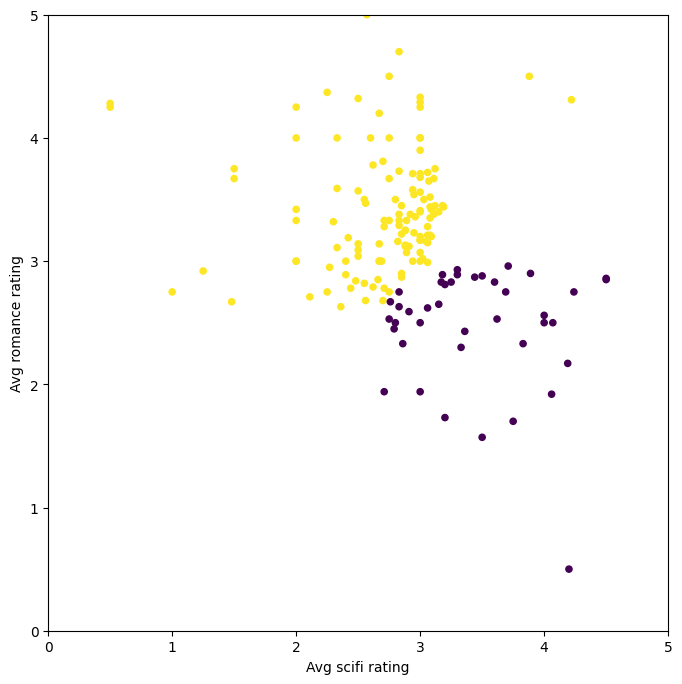

In [9]:
# Let's turn our dataset into a list
X = biased_dataset[['avg_scifi_rating','avg_romance_rating']].values

# Import KMeans
from sklearn.cluster import KMeans

# Create an instance of KMeans to find two clusters
kmeans_1 = KMeans(n_clusters=2)

# Use fit_predict to cluster the dataset
predictions = kmeans_1.fit_predict(X)

# Defining the cluster plotting function
def draw_clusters(biased_dataset, predictions, cmap='viridis'):
    fig = plt.figure(figsize=(8,8))
    ax = fig.add_subplot(111)
    plt.xlim(0, 5)
    plt.ylim(0, 5)
    ax.set_xlabel('Avg scifi rating')
    ax.set_ylabel('Avg romance rating')
    clustered = pd.concat([biased_dataset.reset_index(), pd.DataFrame({'group':predictions})], axis=1)
    plt.scatter(clustered['avg_scifi_rating'], clustered['avg_romance_rating'], c=clustered['group'], s=20, cmap=cmap)

# Plot
draw_clusters(biased_dataset, predictions)

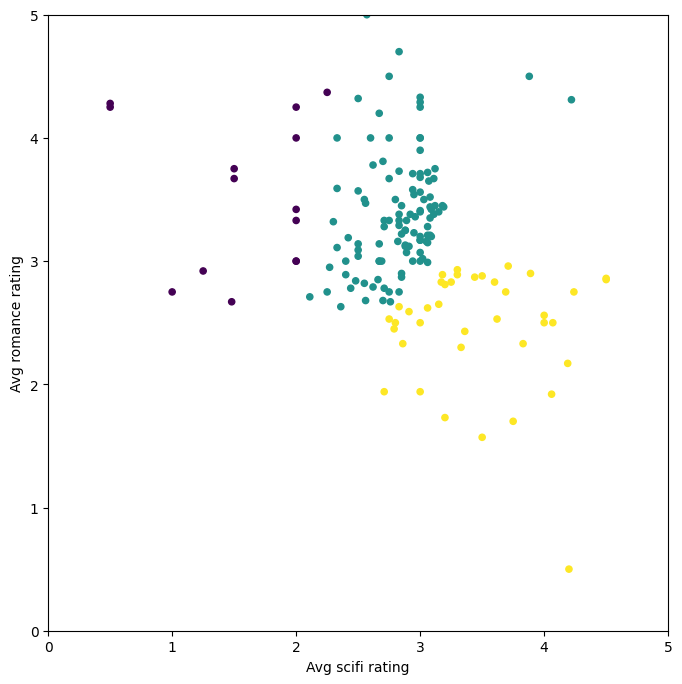

In [10]:
# Create an instance of KMeans to find three clusters
kmeans_2 = KMeans(n_clusters=3)
# Use fit_predict to cluster the dataset
predictions_2 = kmeans_2.fit_predict(X)
# Plot
draw_clusters(biased_dataset, predictions_2)

It is evident now that the science-fiction rating has started to come into play:

    People who like sci-fi and romance modeately belong to the green group.
    People who like scifi but not romance belong to the yello group.
    People who like romance but not sci-fi belong to the purple group.

Finding optimal clusters using silhouette score

/usr/local/lib/python3.11/dist-packages/sklearn/base.py:1389: ConvergenceWarning: Number of distinct clusters (157) found smaller than n_clusters (162). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)


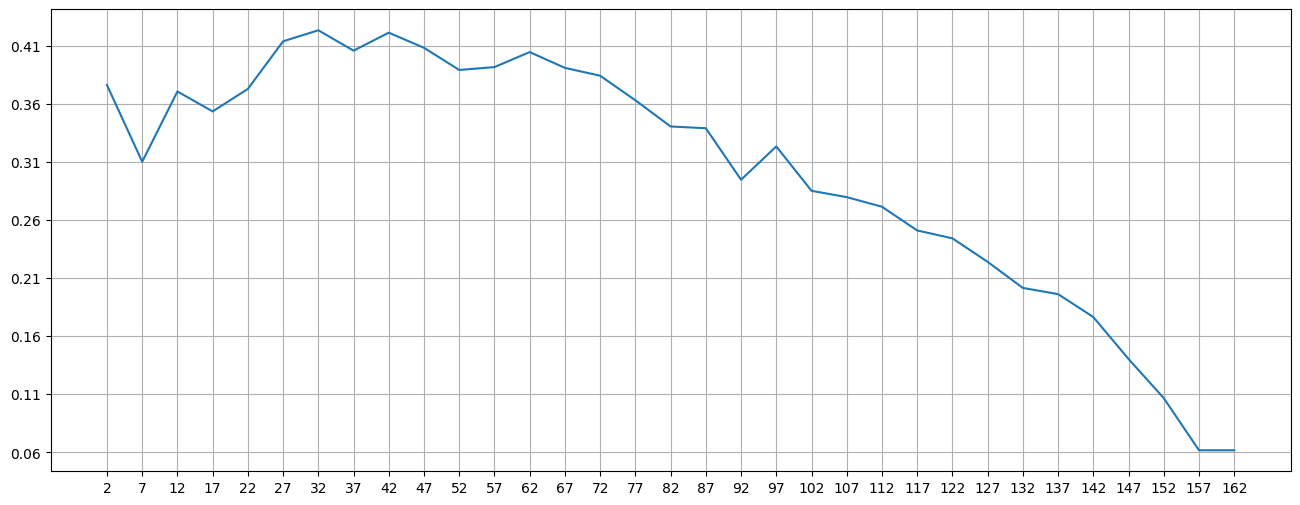

In [11]:
# Selecting our dataset to study
df = biased_dataset[['avg_scifi_rating','avg_romance_rating']]

# Choose the range of k values to test.
# We added a stride of 5 to improve performance. We don't need to calculate the error for every k value
possible_k_values = range(2, len(X)+1, 5)

# Define function to calculate the clustering errors
def clustering_errors(k, data):
    kmeans = KMeans(n_clusters=k).fit(data)
    predictions = kmeans.predict(data)
    #cluster_centers = kmeans.cluster_centers_
    # errors = [mean_squared_error(row, cluster_centers[cluster]) for row, cluster in zip(data.values, predictions)]
    # return sum(errors)
    silhouette_avg = silhouette_score(data, predictions)
    return silhouette_avg

# Calculate error values for all k values we're interested in
errors_per_k = [clustering_errors(k, X) for k in possible_k_values]

# Plot the each value of K vs. the silhouette score at that value
fig, ax = plt.subplots(figsize=(16, 6))
plt.plot(possible_k_values, errors_per_k)

# Ticks and grid
xticks = np.arange(min(possible_k_values), max(possible_k_values)+1, 5.0)
ax.set_xticks(xticks, minor=False)
ax.set_xticks(xticks, minor=True)
ax.xaxis.grid(True, which='both')
yticks = np.arange(round(min(errors_per_k), 2), max(errors_per_k), .05)
ax.set_yticks(yticks, minor=False)
ax.set_yticks(yticks, minor=True)
ax.yaxis.grid(True, which='both')

We will chose the K = 7 as it is the one that yields the best score and will be easier to visualize.



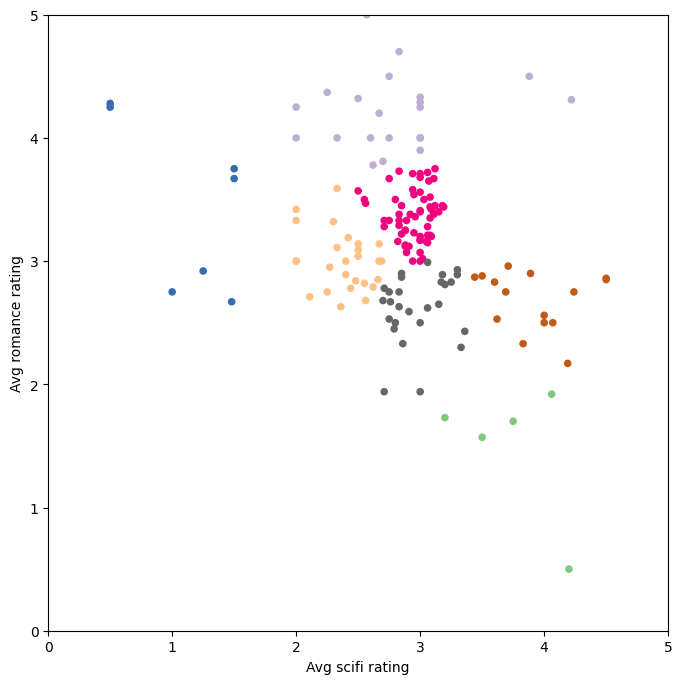

In [12]:
# Create an instance of KMeans to find seven clusters
kmeans_4 = KMeans(n_clusters=7)
# Use fit_predict to cluster the dataset
predictions_4 = kmeans_4.fit_predict(X)
# Plot
draw_clusters(biased_dataset, predictions_4, cmap='Accent')

Up to now, we have only analyzed romance and science-fiction movies. Let us see what happens when adding other genre to our analysis by adding Action movies.

In [13]:
# Select our biased dataset and add action genre
biased_dataset_3_genres = get_genre_ratings(ratings, movies, ['Romance','Sci-Fi', 'Action'],
['avg_romance_rating', 'avg_scifi_rating', 'avg_action_rating'])
# Drop null values
biased_dataset_3_genres = bias_genre_rating_dataset(biased_dataset_3_genres, 3.2, 2.5).dropna()
# Print the number of records and the head of our dataset
print( "Number of records: ", len(biased_dataset_3_genres))
biased_dataset_3_genres.head()

Number of records:  161


,index,avg_romance_rating,avg_scifi_rating,avg_action_rating
0,3,0.50,4.20,3.57
1,4,3.38,2.83,3.32
2,5,3.09,2.50,3.11
3,7,2.65,3.15,3.26
4,9,3.17,3.00,3.12


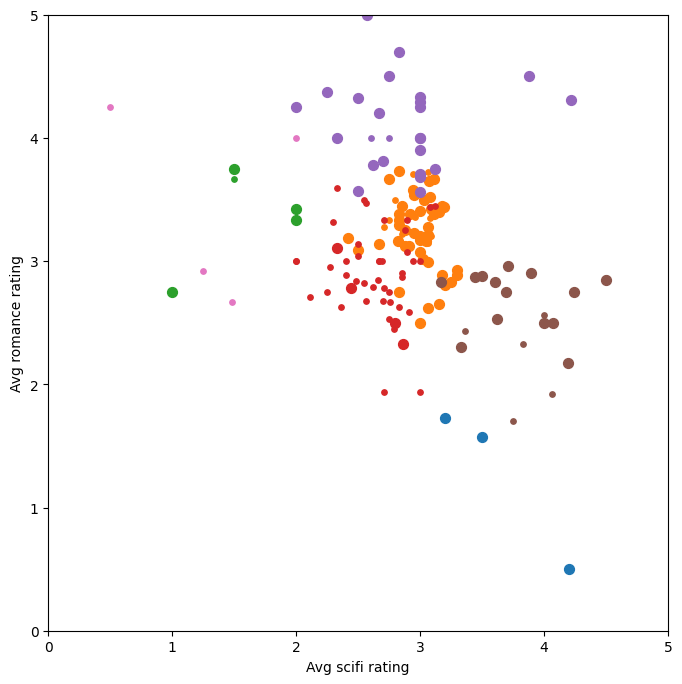

In [14]:
# Turn dataset into a list
X_with_action = biased_dataset_3_genres[['avg_scifi_rating','avg_romance_rating','avg_action_rating']].values# Create an instance of KMeans to find seven clusters
kmeans_5 = KMeans(n_clusters=7)
# Use fit_predict to cluster the dataset
predictions_5 = kmeans_5.fit_predict(X_with_action)
# Define 3d plotting function
def draw_clusters_3d(biased_dataset_3, predictions):
    fig = plt.figure(figsize=(8,8))
    ax = fig.add_subplot(111)
    plt.xlim(0, 5)
    plt.ylim(0, 5)
    ax.set_xlabel('Avg scifi rating')
    ax.set_ylabel('Avg romance rating')
    clustered = pd.concat([biased_dataset_3.reset_index(), pd.DataFrame({'group':predictions})], axis=1)
    colors = itertools.cycle(plt.rcParams["axes.prop_cycle"].by_key()["color"])
    for g in clustered.group.unique():
        color = next(colors)
        for index, point in clustered[clustered.group == g].iterrows():
            if point['avg_action_rating'].astype(float) > 3:
                size = 50
            else:
                size = 15
            plt.scatter(point['avg_scifi_rating'],
                        point['avg_romance_rating'],
                        s=size,
                        color=color)# Plot
draw_clusters_3d(biased_dataset_3_genres, predictions_5)

The size of the dots represent the ratings of the action movies.

# Exercise 1

## Instead of choosing a n_clusters as 7, play around with different k
## Find the optimal no of clusters with 3 genre_ratings data we just created using silhouette score method

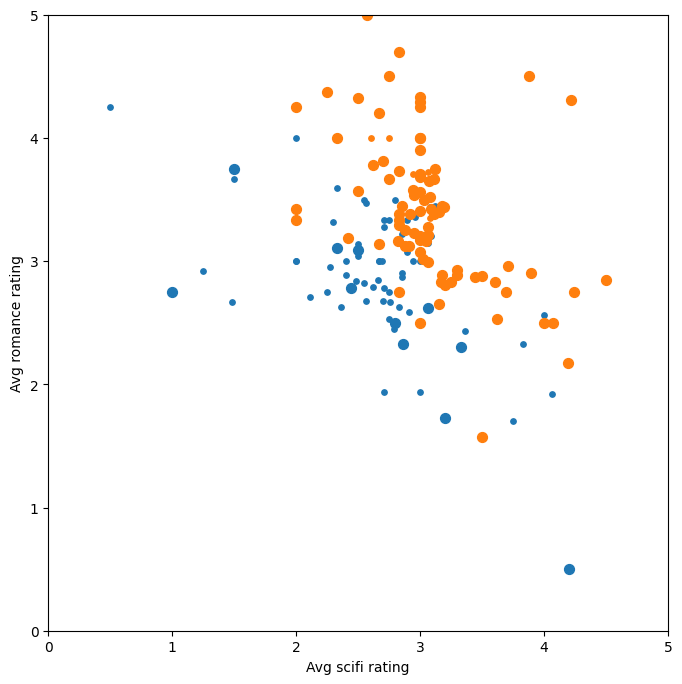

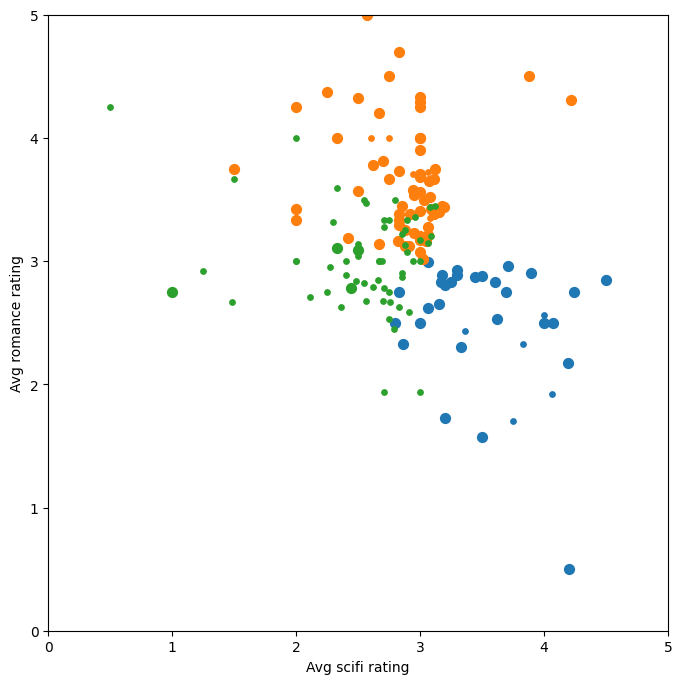

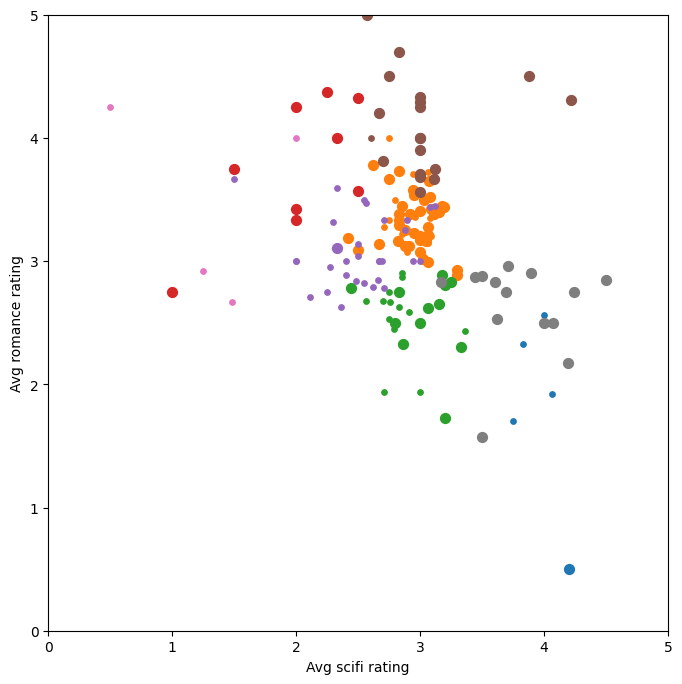

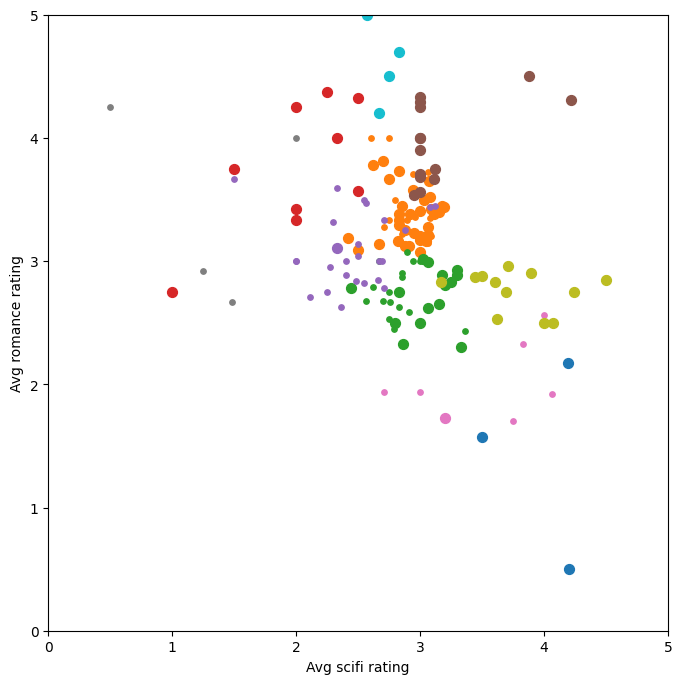

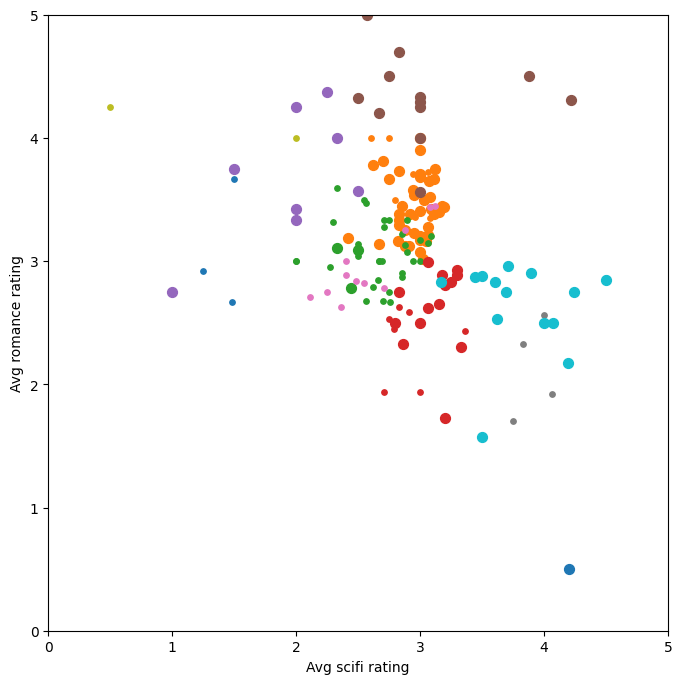

In [56]:
# CODE
k=[2,3,8,10,11]
for i in k:
  X_with_action = biased_dataset_3_genres[['avg_scifi_rating','avg_romance_rating','avg_action_rating']].values# Create an instance of KMeans to find seven clusters
  kmeans_5 = KMeans(n_clusters=i)
  # Use fit_predict to cluster the dataset
  predictions_5 = kmeans_5.fit_predict(X_with_action)
  # Define 3d plotting function
  def draw_clusters_3d(biased_dataset_3, predictions):
      fig = plt.figure(figsize=(8,8))
      ax = fig.add_subplot(111)
      plt.xlim(0, 5)
      plt.ylim(0, 5)
      ax.set_xlabel('Avg scifi rating')
      ax.set_ylabel('Avg romance rating')
      clustered = pd.concat([biased_dataset_3.reset_index(), pd.DataFrame({'group':predictions})], axis=1)
      colors = itertools.cycle(plt.rcParams["axes.prop_cycle"].by_key()["color"])
      for g in clustered.group.unique():
          color = next(colors)
          for index, point in clustered[clustered.group == g].iterrows():
              if point['avg_action_rating'].astype(float) > 3:
                  size = 50
              else:
                  size = 15
              plt.scatter(point['avg_scifi_rating'],
                          point['avg_romance_rating'],
                          s=size,
                          color=color)# Plot
  draw_clusters_3d(biased_dataset_3_genres, predictions_5)

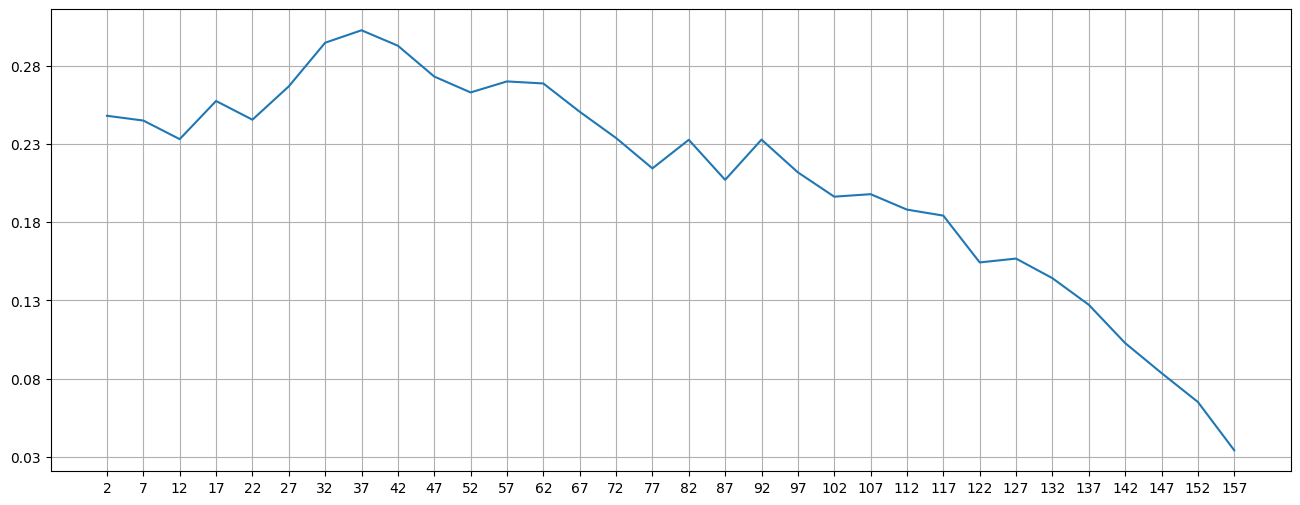

In [60]:
X=biased_dataset_3_genres[['avg_scifi_rating','avg_romance_rating','avg_action_rating']].values
possible_k_values = range(2, len(X)+1, 5)
errors_per_k = [clustering_errors(k, X) for k in possible_k_values]

fig, ax = plt.subplots(figsize=(16, 6))
plt.plot(possible_k_values, errors_per_k)

xticks = np.arange(min(possible_k_values), max(possible_k_values)+1, 5.0)
ax.set_xticks(xticks, minor=False)
ax.set_xticks(xticks, minor=True)
ax.xaxis.grid(True, which='both')
yticks = np.arange(round(min(errors_per_k), 2), max(errors_per_k), .05)
ax.set_yticks(yticks, minor=False)
ax.set_yticks(yticks, minor=True)
ax.yaxis.grid(True, which='both')
#12 and 22 can be an optimal number

### Taking users into consideration

Once we have seen and understood how the K-Means algorithm group the users by their movie genre preferences, we are going to take a bigger picture of the dataset and explore how users rate individual movies.

To do so, we will subset the dataset by ‘userid’ vs ‘user rating’ as follows.

In [16]:
# Merge the two tables then pivot so we have Users X Movies dataframe
ratings_title = pd.merge(ratings, movies[['movieId', 'title']], on='movieId' )
user_movie_ratings = pd.pivot_table(ratings_title, index='userId', columns= 'title', values='rating')

# Print he number of dimensions and a subset of the dataset
print('dataset dimensions: ', user_movie_ratings.shape, '\n\nSubset example:')
user_movie_ratings.iloc[:6, :10]

dataset dimensions:  (610, 9719) 

Subset example:


title,'71 (2014),'Hellboy': The Seeds of Creation (2004),'Round Midnight (1986),'Salem's Lot (2004),'Til There Was You (1997),'Tis the Season for Love (2015),"'burbs, The (1989)",'night Mother (1986),(500) Days of Summer (2009),*batteries not included (1987)
userId,,,,,,,,,,
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [18]:
# Define Function to get the most rated movies
def get_most_rated_movies(user_movie_ratings, max_number_of_movies):
    # 1- Count
    user_movie_ratings = pd.concat([user_movie_ratings, pd.DataFrame([user_movie_ratings.count()])], ignore_index=True)
    # 2- sort
    user_movie_ratings_sorted = user_movie_ratings.sort_values(len(user_movie_ratings)-1, axis=1, ascending=False)
    user_movie_ratings_sorted = user_movie_ratings_sorted.drop(user_movie_ratings_sorted.tail(1).index)
    # 3- slice
    most_rated_movies = user_movie_ratings_sorted.iloc[:, :max_number_of_movies]
    return most_rated_movies

# Define function to get the user who rate a movie the most
def get_users_who_rate_the_most(most_rated_movies, n_users):
    most_rated_movies['num_ratings'] = - most_rated_movies.isnull().sum(axis=1)
    most_rated_movies = most_rated_movies.sort_values(by=['num_ratings'], ascending=False)
    most_rated_movies = most_rated_movies.iloc[:n_users, :]
    most_rated_movies = most_rated_movies.drop('num_ratings', axis=1)
    return most_rated_movies

# Define the sorting by rating function
def sort_by_rating_density(user_movie_ratings, n_movies, n_users):
    most_rated_movies = get_most_rated_movies(user_movie_ratings, n_movies)
    most_rated_movies = get_users_who_rate_the_most(most_rated_movies, n_users)
    return most_rated_movies

# choose the number of movies and users and sort
n_movies = 30
n_users = 18
most_rated_movies_users_selection = sort_by_rating_density(user_movie_ratings, n_movies, n_users)

# Print the result
# print(most_rated_movies_users_selection)
print('dataset dimensions: ', most_rated_movies_users_selection.shape)
print(most_rated_movies_users_selection.head())

dataset dimensions:  (18, 30)
title  Forrest Gump (1994)  Shawshank Redemption, The (1994)  \
413                    5.0                               5.0   
589                    5.0                               4.5   
473                    3.0                               5.0   
479                    5.0                               5.0   
67                     3.5                               3.0   

title  Pulp Fiction (1994)  Silence of the Lambs, The (1991)  \
413                    5.0                               4.0   
589                    4.5                               3.5   
473                    4.0                               4.5   
479                    4.0                               4.5   
67                     2.0                               3.5   

title  Matrix, The (1999)  Star Wars: Episode IV - A New Hope (1977)  \
413                   5.0                                        5.0   
589                   4.0                               

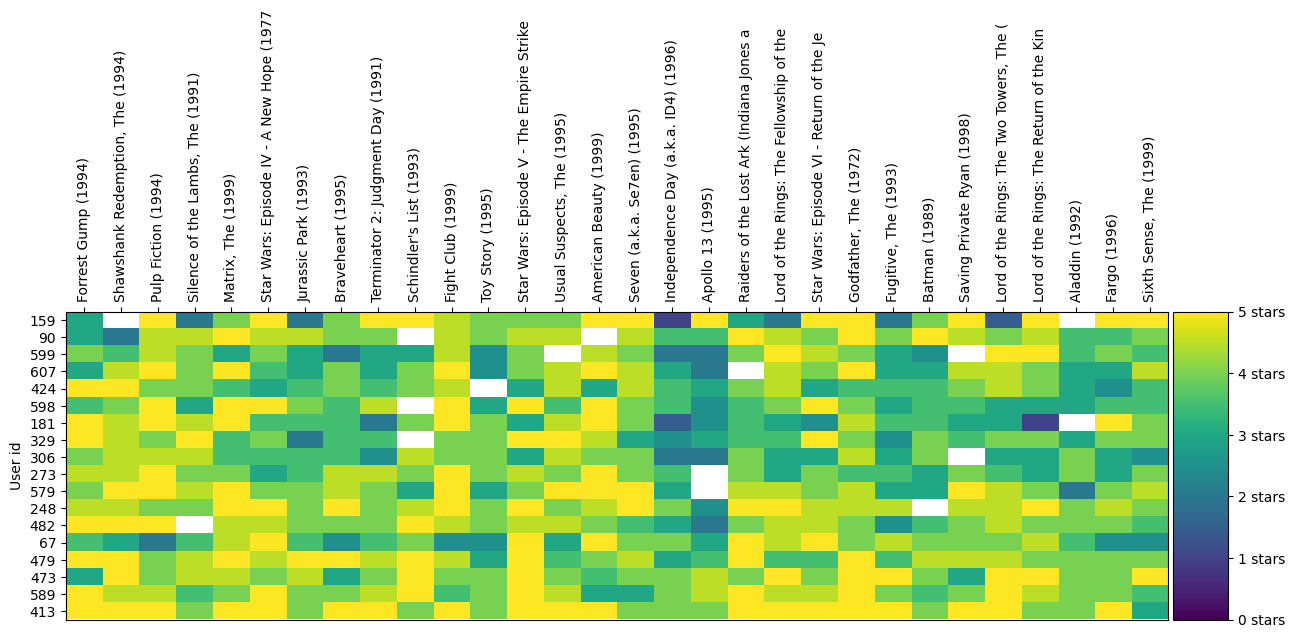

In [19]:
# Define the plotting heatmap function
def draw_movies_heatmap(most_rated_movies_users_selection, axis_labels=True):

    fig = plt.figure(figsize=(15,4))
    ax = plt.gca()

    # Draw heatmap
    heatmap = ax.imshow(most_rated_movies_users_selection,  interpolation='nearest', vmin=0, vmax=5, aspect='auto')
    if axis_labels:
        ax.set_yticks(np.arange(most_rated_movies_users_selection.shape[0]) , minor=False)
        ax.set_xticks(np.arange(most_rated_movies_users_selection.shape[1]) , minor=False)
        ax.invert_yaxis()
        ax.xaxis.tick_top()
        labels = most_rated_movies_users_selection.columns.str[:40]
        ax.set_xticklabels(labels, minor=False)
        ax.set_yticklabels(most_rated_movies_users_selection.index, minor=False)
        plt.setp(ax.get_xticklabels(), rotation=90)
    else:
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

    ax.grid(False)
    ax.set_ylabel('User id')# Separate heatmap from color bar
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)# Color bar
    cbar = fig.colorbar(heatmap, ticks=[5, 4, 3, 2, 1, 0], cax=cax)
    cbar.ax.set_yticklabels(['5 stars', '4 stars','3 stars','2 stars','1 stars','0 stars'])
    plt.show()# Print the heatmap
draw_movies_heatmap(most_rated_movies_users_selection)

In [20]:
# Pivot the dataset and choose the first 1000 movies
user_movie_ratings =  pd.pivot_table(ratings_title, index='userId', columns= 'title', values='rating')
most_rated_movies_1k = get_most_rated_movies(user_movie_ratings, 1000).replace(np.nan, 0)

In [21]:
from scipy import sparse

# Conversion to sparse csr matrix
sparse_ratings = sparse.csr_matrix(most_rated_movies_1k.values)

### Large Scale Clustering

In [23]:
# 20 clusters
predictions = KMeans(n_clusters=20, algorithm='lloyd').fit_predict(sparse_ratings)
# Select the mas number of users and movies heatmap cluster
# Cluster and print some of them
clustered = pd.concat([get_most_rated_movies(user_movie_ratings, 1000).reset_index(), pd.DataFrame({'group':predictions})], axis=1)
# draw_movie_clusters(clustered, max_users, max_movies)

### Predictions and Recommendation

     Forrest Gump (1994)  Shawshank Redemption, The (1994)  \
17                   4.5                               5.0   
61                   5.0                               4.0   
62                   3.5                               5.0   
102                  4.0                               5.0   
104                  3.5                               5.0   
121                  5.0                               5.0   
281                  4.5                               4.5   
297                  3.0                               3.5   
304                  4.5                               5.0   
338                  4.0                               4.0   
494                  4.0                               5.0   
524                  4.0                               4.5   
533                  4.5                               NaN   
559                  3.5                               NaN   
560                  4.0                               5.0   
595     

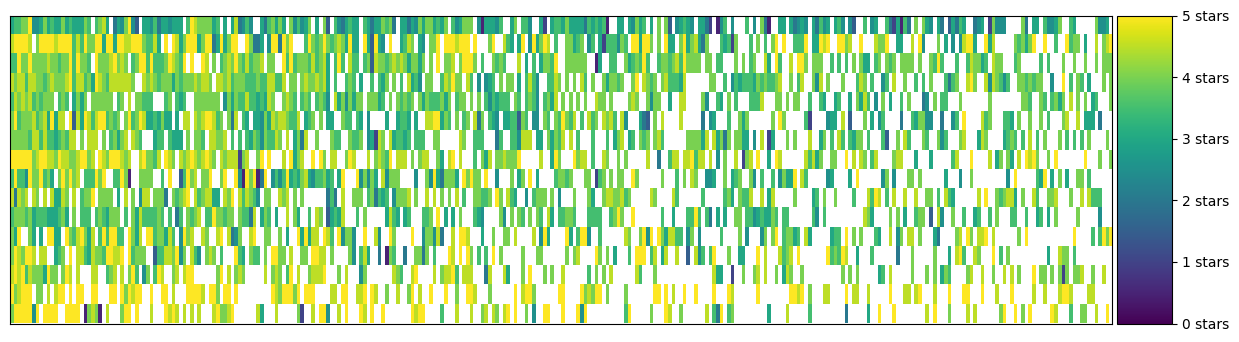

In [24]:
# Pick a cluster ID from the clusters above
cluster_number = 11
# Let's filter to only see the region of the dataset with the most number of values
n_users = 75
n_movies = 300
cluster = clustered[clustered.group == cluster_number].drop(['index', 'group'], axis=1)
print(cluster)
# Sort and print the cluster
cluster = sort_by_rating_density(cluster, n_movies, n_users)
draw_movies_heatmap(cluster, axis_labels=False)

In [25]:
# Fill in the name of the column/movie. e.g. 'Forrest Gump (1994)'
movie_name = "Matrix, The (1999)"
cluster[movie_name].mean()

4.366666666666666

In [26]:
# The average rating of 20 movies as rated by the users in the cluster
cluster.mean().head(20)

,0
Forrest Gump (1994),4.062500
"Dark Knight, The (2008)",4.218750
Inception (2010),4.375000
"Matrix, The (1999)",4.366667
Kill Bill: Vol. 2 (2004),4.166667
Fight Club (1999),4.566667
Pirates of the Caribbean: The Curse of the Black Pearl (2003),3.785714
Ocean's Eleven (2001),3.964286
"Dark Knight Rises, The (2012)",4.000000
Kill Bill: Vol. 1 (2003),4.178571


In [27]:
cluster

,Forrest Gump (1994),"Dark Knight, The (2008)",Inception (2010),"Matrix, The (1999)",Kill Bill: Vol. 2 (2004),Fight Club (1999),Pirates of the Caribbean: The Curse of the Black Pearl (2003),Ocean's Eleven (2001),"Dark Knight Rises, The (2012)",Kill Bill: Vol. 1 (2003),...,"Bourne Ultimatum, The (2007)",Aladdin (1992),Ocean's Thirteen (2007),"Hitchhiker's Guide to the Galaxy, The (2005)","Bug's Life, A (1998)","South Park: Bigger, Longer and Uncut (1999)",Spider-Man 3 (2007),"Aviator, The (2004)",Argo (2012),Lord of War (2005)
7,3.0,3.5,3.5,4.0,4.0,5.0,2.5,2.5,3.0,4.0,...,NaN,NaN,NaN,NaN,NaN,4.0,2.5,2.5,3.0,NaN
8,4.5,5.0,5.0,5.0,5.0,4.5,NaN,4.0,5.0,5.0,...,4.0,NaN,3.0,NaN,NaN,4.5,NaN,4.0,4.5,5.0
4,3.5,3.5,5.0,4.0,4.0,5.0,4.0,4.0,4.0,4.0,...,NaN,NaN,4.0,NaN,NaN,4.0,NaN,4.0,4.0,4.0
0,4.5,4.0,4.5,4.5,3.5,4.5,4.5,4.0,4.0,3.5,...,4.0,3.5,NaN,3.0,NaN,NaN,NaN,4.0,NaN,4.0
13,3.5,4.5,4.0,4.5,4.0,4.5,3.5,4.0,3.5,4.0,...,4.0,NaN,4.0,NaN,3.0,3.5,NaN,NaN,NaN,4.0
14,4.0,5.0,3.5,4.0,4.0,4.0,4.5,3.5,4.0,4.5,...,4.5,NaN,3.0,3.0,3.0,NaN,2.0,NaN,NaN,NaN
11,4.0,4.0,4.0,4.0,4.0,3.5,4.5,4.5,3.5,4.5,...,NaN,3.5,NaN,4.0,NaN,NaN,NaN,NaN,4.0,NaN
1,5.0,5.0,5.0,5.0,5.0,5.0,4.0,4.5,5.0,5.0,...,NaN,NaN,5.0,NaN,NaN,NaN,4.0,NaN,NaN,4.0
2,3.5,5.0,3.5,3.5,2.5,5.0,4.0,4.0,5.0,3.5,...,4.0,4.0,NaN,3.5,NaN,NaN,NaN,NaN,NaN,NaN
12,4.5,2.0,4.5,4.0,4.5,NaN,4.5,4.0,NaN,4.5,...,NaN,4.5,NaN,4.5,3.5,3.5,3.5,NaN,NaN,NaN


In [28]:
# Predict for a specific user

# Pick a user ID from the dataset
user_id = 7
# Get all this user's ratings
user_2_ratings  = cluster.loc[user_id, :]
# Which movies did they not rate?
user_2_unrated_movies =  user_2_ratings[user_2_ratings.isnull()]
# What are the ratings of these movies the user did not rate?
avg_ratings = pd.concat([user_2_unrated_movies, cluster.mean()], axis=1, join='inner').loc[:,0]
# Let's sort by rating so the highest rated movies are presented first
avg_ratings.sort_values(ascending=False)[:20]

,0
12 Angry Men (1957),4.571429
American Gangster (2007),4.500000
"Green Mile, The (1999)",4.437500
"Silence of the Lambs, The (1991)",4.423077
Life Is Beautiful (La Vita è bella) (1997),4.357143
Lord of War (2005),4.333333
"Sixth Sense, The (1999)",4.333333
Scarface (1983),4.318182
Howl's Moving Castle (Hauru no ugoku shiro) (2004),4.312500
WALL·E (2008),4.291667


## Using Collaborative Filtering (With fast.ai)

In [29]:
! [ -e /content ] && pip install -Uqq fastai

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 113.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 27.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 55.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 7.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 19.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 93.5 MB/s eta 0:00:00


In [30]:
from fastai.tabular.all import *
from fastai.collab import *

### Training a model

For this, we will use the [Movielens 100k data dataset](https://grouplens.org/datasets/movielens/100k/). We can download it easily and decompress it with the following function:

In [31]:
path = untar_data(URLs.ML_100k)

The main table is in `u.data`. Since it's not a proper csv, we have to specify a few things while opening it: the tab delimiter, the columns we want to keep and their names.

In [32]:
ratings = pd.read_csv(path/'u.data', delimiter='\t', header=None,
                      usecols=(0,1,2), names=['user','movie','rating'])
ratings.head()

,user,movie,rating
0,196,242,3
1,186,302,3
2,22,377,1
3,244,51,2
4,166,346,1


Movie ids are not ideal to look at things, so we load the corresponding movie id to the title that is in the table `u.item`:

In [33]:
movies = pd.read_csv(path/'u.item',  delimiter='|', encoding='latin-1',
                     usecols=(0,1), names=('movie','title'), header=None)
movies.head()

,movie,title
0,1,Toy Story (1995)
1,2,GoldenEye (1995)
2,3,Four Rooms (1995)
3,4,Get Shorty (1995)
4,5,Copycat (1995)


Next we merge it to our ratings table:

In [34]:
ratings = ratings.merge(movies)
ratings.head()

,user,movie,rating,title
0,196,242,3,Kolya (1996)
1,186,302,3,L.A. Confidential (1997)
2,22,377,1,Heavyweights (1994)
3,244,51,2,Legends of the Fall (1994)
4,166,346,1,Jackie Brown (1997)


We can then build a `DataLoaders` object from this table. By default, it takes the first column for user, the second column for the item (here our movies) and the third column for the ratings. We need to change the value of `item_name` in our case, to use the titles instead of the ids:

In [35]:
dls = CollabDataLoaders.from_df(ratings, item_name='title', bs=64)

In all applications, when the data has been assembled in a `DataLoaders`, you can have a look at it with the `show_batch` method:

In [36]:
dls.show_batch()

,user,title,rating
0,618,Dazed and Confused (1993),4
1,383,"Postino, Il (1994)",5
2,161,Groundhog Day (1993),5
3,291,Heavy Metal (1981),4
4,538,Leaving Las Vegas (1995),1
5,892,Meet John Doe (1941),5
6,606,Much Ado About Nothing (1993),5
7,561,Mouse Hunt (1997),1
8,293,Tie Me Up! Tie Me Down! (1990),3
9,481,"Englishman Who Went Up a Hill, But Came Down a Mountain, The (1995)",4


fastai can create and train a collaborative filtering model by using `collab_learner`:

In [37]:
learn = collab_learner(dls, n_factors=50, y_range=(0, 5.5))

It uses a simple dot product model with 50 latent factors. To train it using the 1cycle policy, we just run this command:

In [38]:
learn.fit_one_cycle(5, 5e-3, wd=0.1)

epoch,train_loss,valid_loss,time
0,0.882247,0.946167,00:17
1,0.676532,0.889858,00:09
2,0.552032,0.867939,00:07
3,0.470758,0.857313,00:07
4,0.454627,0.852233,00:06


Here's [some benchmarks](https://www.librec.net/release/v1.3/example.html) on the same dataset for the popular Librec system for collaborative filtering. They show best results based on RMSE of 0.91 (scroll down to the 100k dataset), which corresponds to an MSE of `0.91**2 = 0.83`. So in less than a minute, we got pretty good results!

### Interpretation

Let's analyze the results of our previous model. We will keep the 1000 most rated movies for this:

In [39]:
g = ratings.groupby('title')['rating'].count()
top_movies = g.sort_values(ascending=False).index.values[:1000]
top_movies[:10]

array(['Star Wars (1977)', 'Contact (1997)', 'Fargo (1996)',
       'Return of the Jedi (1983)', 'Liar Liar (1997)',
       'English Patient, The (1996)', 'Scream (1996)', 'Toy Story (1995)',
       'Air Force One (1997)', 'Independence Day (ID4) (1996)'],
      dtype=object)

### Movie bias

Our model has learned one bias per movie, a unique number independent of users that can be interpreted as the intrinsic "value" of the movie. We can grab the bias of each movie in our `top_movies` list with the following command:

In [40]:
movie_bias = learn.model.bias(top_movies, is_item=True)
movie_bias.shape

torch.Size([1000])

Let's compare those biases with the average ratings:

In [41]:
mean_ratings = ratings.groupby('title')['rating'].mean()
movie_ratings = [(b, i, mean_ratings.loc[i]) for i,b in zip(top_movies,movie_bias)]

Now let's have a look at the movies with the worst bias:

In [42]:
item0 = lambda o:o[0]
sorted(movie_ratings, key=item0)[:15]

[(tensor(-0.3039),
  'Children of the Corn: The Gathering (1996)',
  1.3157894736842106),
 (tensor(-0.3017),
  'Lawnmower Man 2: Beyond Cyberspace (1996)',
  1.7142857142857142),
 (tensor(-0.2907), 'Bio-Dome (1996)', 1.903225806451613),
 (tensor(-0.2749), 'Thinner (1996)', 2.4489795918367347),
 (tensor(-0.2717), 'Mortal Kombat: Annihilation (1997)', 1.9534883720930232),
 (tensor(-0.2710), 'Showgirls (1995)', 1.9565217391304348),
 (tensor(-0.2655), 'Cable Guy, The (1996)', 2.339622641509434),
 (tensor(-0.2499), 'Crow: City of Angels, The (1996)', 1.9487179487179487),
 (tensor(-0.2282), 'Vegas Vacation (1997)', 2.4),
 (tensor(-0.2276), 'Speed 2: Cruise Control (1997)', 2.1315789473684212),
 (tensor(-0.2269), 'Tales from the Hood (1995)', 2.037037037037037),
 (tensor(-0.2269), 'Stuart Saves His Family (1995)', 2.125),
 (tensor(-0.2219), "Pete's Dragon (1977)", 2.7209302325581395),
 (tensor(-0.1970), 'Striptease (1996)', 2.2388059701492535),
 (tensor(-0.1953), 'Barb Wire (1996)', 1.9333333

Or the ones with the best bias:

In [43]:
sorted(movie_ratings, key=lambda o: o[0], reverse=True)[:15]

[(tensor(0.6249), 'Titanic (1997)', 4.2457142857142856),
 (tensor(0.6049), 'Shawshank Redemption, The (1994)', 4.445229681978798),
 (tensor(0.5465), 'As Good As It Gets (1997)', 4.196428571428571),
 (tensor(0.5368), 'Silence of the Lambs, The (1991)', 4.28974358974359),
 (tensor(0.5161), 'Star Wars (1977)', 4.3584905660377355),
 (tensor(0.4890), "Schindler's List (1993)", 4.466442953020135),
 (tensor(0.4789), 'Good Will Hunting (1997)', 4.262626262626263),
 (tensor(0.4660), 'L.A. Confidential (1997)', 4.161616161616162),
 (tensor(0.4570), 'Vertigo (1958)', 4.251396648044692),
 (tensor(0.4564), 'Treasure of the Sierra Madre, The (1948)', 4.1),
 (tensor(0.4407), '12 Angry Men (1957)', 4.344),
 (tensor(0.4378), 'Fugitive, The (1993)', 4.044642857142857),
 (tensor(0.4371), 'Godfather, The (1972)', 4.283292978208232),
 (tensor(0.4370), 'Usual Suspects, The (1995)', 4.385767790262173),
 (tensor(0.4344), 'Much Ado About Nothing (1993)', 4.0625)]

There is certainly a strong correlation!

### Movie weights

Now let's try to analyze the latent factors our model has learned. We can grab the weights for each movie in `top_movies` the same way as we did for the bias before.

In [44]:
movie_w = learn.model.weight(top_movies, is_item=True)
movie_w.shape

torch.Size([1000, 50])

Let's try a PCA to reduce the dimensions and see if we can see what the model learned:

In [45]:
movie_pca = movie_w.pca(3)
movie_pca.shape

torch.Size([1000, 3])

In [46]:
fac0,fac1,fac2 = movie_pca.t()
movie_comp = [(f, i) for f,i in zip(fac0, top_movies)]

Here are the highest score on the first dimension:

In [47]:
sorted(movie_comp, key=itemgetter(0), reverse=True)[:10]

[(tensor(1.0839), 'Chinatown (1974)'),
 (tensor(1.0425), 'Casablanca (1942)'),
 (tensor(1.0366),
  'Dr. Strangelove or: How I Learned to Stop Worrying and Love the Bomb (1963)'),
 (tensor(1.0041), 'Three Colors: Red (1994)'),
 (tensor(1.0002), 'Wrong Trousers, The (1993)'),
 (tensor(0.9914), 'Ran (1985)'),
 (tensor(0.9814), 'Lawrence of Arabia (1962)'),
 (tensor(0.9812), 'Godfather, The (1972)'),
 (tensor(0.9701), 'Close Shave, A (1995)'),
 (tensor(0.9438), 'Fargo (1996)')]

And the worst:

In [48]:
sorted(movie_comp, key=itemgetter(0))[:10]

[(tensor(-1.2588), 'Free Willy 3: The Rescue (1997)'),
 (tensor(-1.1957), "McHale's Navy (1997)"),
 (tensor(-1.1772), 'Jungle2Jungle (1997)'),
 (tensor(-1.1626), 'Mouse Hunt (1997)'),
 (tensor(-1.1041), 'Leave It to Beaver (1997)'),
 (tensor(-1.0734), 'Barb Wire (1996)'),
 (tensor(-1.0626), 'That Darn Cat! (1997)'),
 (tensor(-1.0539), 'Vegas Vacation (1997)'),
 (tensor(-1.0474), 'D3: The Mighty Ducks (1996)'),
 (tensor(-1.0116), 'Children of the Corn: The Gathering (1996)')]

Same thing for our second dimension:

In [49]:
movie_comp = [(f, i) for f,i in zip(fac1, top_movies)]

In [50]:
sorted(movie_comp, key=itemgetter(0), reverse=True)[:10]

[(tensor(1.1052), 'Raiders of the Lost Ark (1981)'),
 (tensor(1.0977), 'Braveheart (1995)'),
 (tensor(1.0907), 'Titanic (1997)'),
 (tensor(1.0312), 'Forrest Gump (1994)'),
 (tensor(0.8772), 'Ghost (1990)'),
 (tensor(0.8581), 'Hunt for Red October, The (1990)'),
 (tensor(0.8332), 'Field of Dreams (1989)'),
 (tensor(0.8233), 'Shawshank Redemption, The (1994)'),
 (tensor(0.8152), 'Time to Kill, A (1996)'),
 (tensor(0.8000), 'Phenomenon (1996)')]

In [51]:
sorted(movie_comp, key=itemgetter(0))[:10]

[(tensor(-0.8972), 'Cabin Boy (1994)'),
 (tensor(-0.8714), 'Trainspotting (1996)'),
 (tensor(-0.8370), 'Crumb (1994)'),
 (tensor(-0.8189), 'Showgirls (1995)'),
 (tensor(-0.7960), 'To Die For (1995)'),
 (tensor(-0.7948), 'Ready to Wear (Pret-A-Porter) (1994)'),
 (tensor(-0.7882), 'Leave It to Beaver (1997)'),
 (tensor(-0.7875), 'Very Brady Sequel, A (1996)'),
 (tensor(-0.7783), 'Spice World (1997)'),
 (tensor(-0.7286), 'Crow: City of Angels, The (1996)')]

And we can even plot the movies according to their scores on those dimensions:

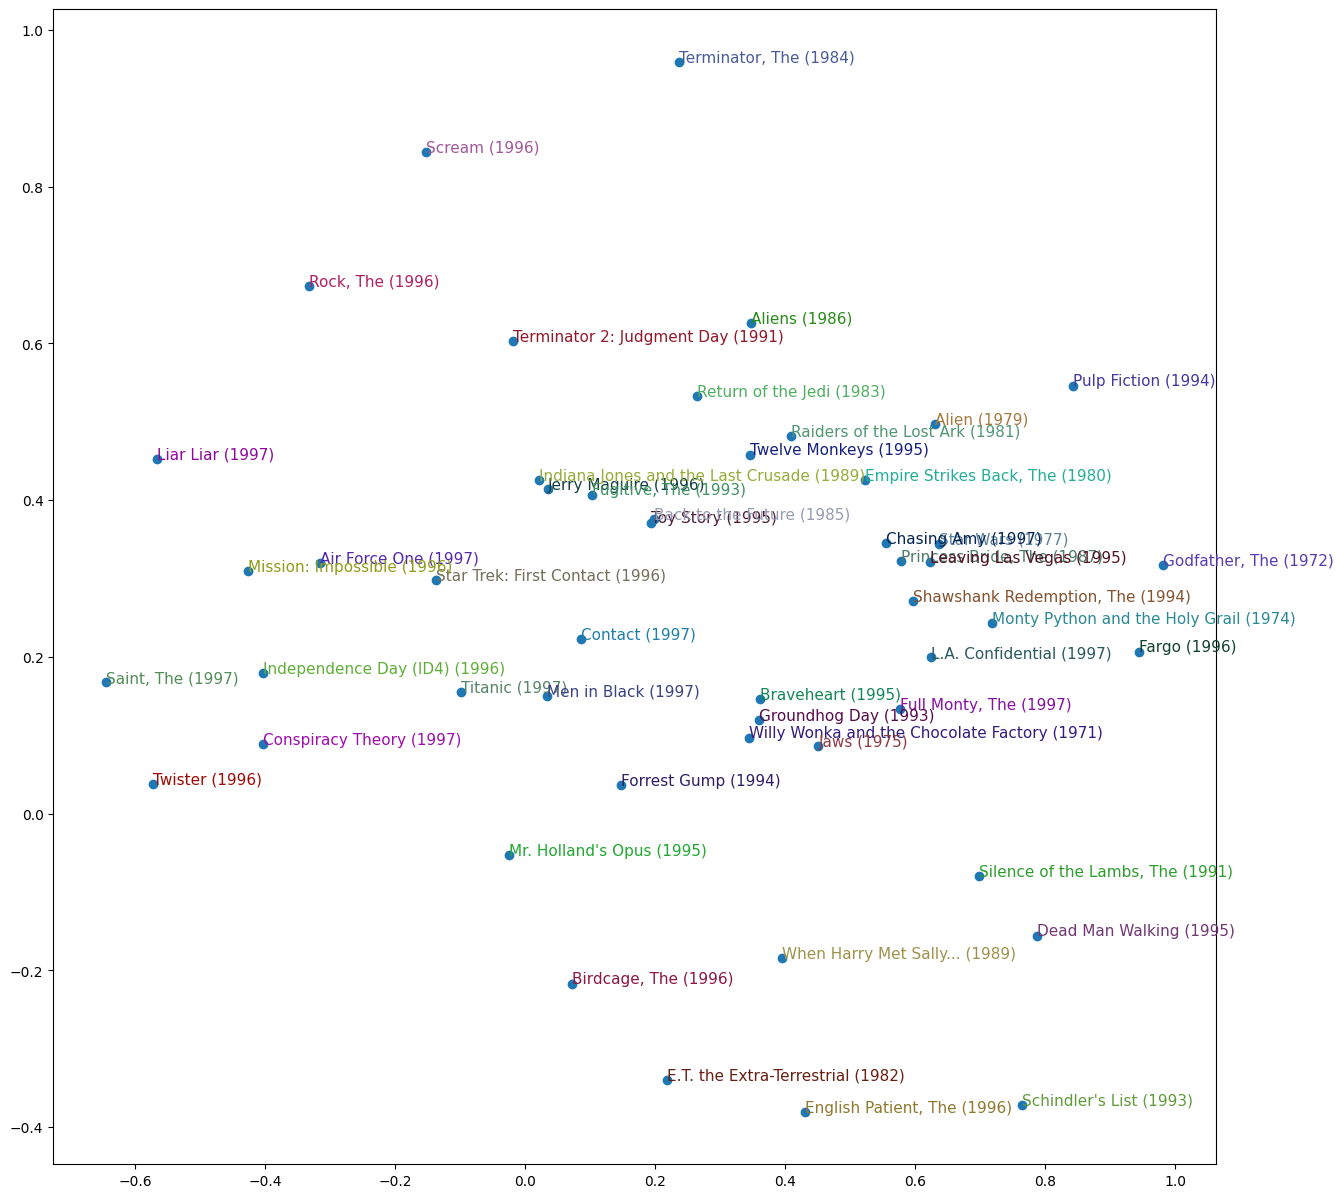

In [52]:
idxs = np.random.choice(len(top_movies), 50, replace=False)
idxs = list(range(50))
X = fac0[idxs]
Y = fac2[idxs]
plt.figure(figsize=(15,15))
plt.scatter(X, Y)
for i, x, y in zip(top_movies[idxs], X, Y):
    plt.text(x,y,i, color=np.random.rand(3)*0.7, fontsize=11)
plt.show()

# Exercise 2

## Play around with different collaborative filtering model parameters such as n_factors and other parameters.
## Identify if any such parameters have impact on the speed of convergence or the performance on the model

In [53]:
# CODE

In [55]:
# task: Play around with different collaborative filtering model parameters such as n_factors and other parameters.

# Try different n_factors
n_factors_list = [20, 30, 40, 50, 60]
for n_factors in n_factors_list:
  print(f"Training with n_factors = {n_factors}")
  learn = collab_learner(dls, n_factors=n_factors, y_range=(0, 5.5))
  learn.fit_one_cycle(5, 5e-3, wd=0.1)
  print(f"Finished training with n_factors = {n_factors}")

# Try different learning rates
lr_list = [1e-2, 5e-3, 1e-3, 5e-4]
for lr in lr_list:
  print(f"Training with learning rate = {lr}")
  learn = collab_learner(dls, n_factors=50, y_range=(0, 5.5))
  learn.fit_one_cycle(5, lr, wd=0.1)
  print(f"Finished training with learning rate = {lr}")

# Try different weight decay values
wd_list = [0.01, 0.1, 0.5]
for wd in wd_list:
  print(f"Training with weight decay = {wd}")
  learn = collab_learner(dls, n_factors=50, y_range=(0, 5.5))
  learn.fit_one_cycle(5, 5e-3, wd=wd)
  print(f"Finished training with weight decay = {wd}")
#n_factors and decay rate have more effect on convergence

Training with n_factors = 20


epoch,train_loss,valid_loss,time
0,0.892374,0.929236,00:07
1,0.774588,0.880601,00:07
2,0.689858,0.851385,00:07
3,0.633102,0.833113,00:06
4,0.657749,0.830035,00:07


Finished training with n_factors = 20
Training with n_factors = 30


epoch,train_loss,valid_loss,time
0,0.876554,0.941988,00:07
1,0.727391,0.880370,00:07
2,0.631818,0.853785,00:07
3,0.562985,0.833449,00:06
4,0.556861,0.831740,00:07


Finished training with n_factors = 30
Training with n_factors = 40


epoch,train_loss,valid_loss,time
0,0.915056,0.950304,00:07
1,0.717490,0.891157,00:06
2,0.585528,0.863006,00:07
3,0.511983,0.844372,00:07
4,0.475457,0.839929,00:08


Finished training with n_factors = 40
Training with n_factors = 50


epoch,train_loss,valid_loss,time
0,0.888040,0.946972,00:07
1,0.704199,0.882529,00:06
2,0.535643,0.862220,00:07
3,0.432944,0.852620,00:07
4,0.451543,0.847399,00:06


Finished training with n_factors = 50
Training with n_factors = 60


epoch,train_loss,valid_loss,time
0,0.872201,0.935137,00:07
1,0.626170,0.889759,00:06
2,0.501919,0.878500,00:10
3,0.406295,0.861915,00:07
4,0.393848,0.857018,00:07


Finished training with n_factors = 60
Training with learning rate = 0.01


epoch,train_loss,valid_loss,time
0,0.828016,0.966289,00:07
1,0.635421,0.956213,00:07
2,0.509215,0.903290,00:06
3,0.407454,0.870744,00:07
4,0.371508,0.863921,00:07


Finished training with learning rate = 0.01
Training with learning rate = 0.005


epoch,train_loss,valid_loss,time
0,0.898380,0.945839,00:07
1,0.669773,0.885197,00:08
2,0.540457,0.860324,00:06
3,0.454003,0.846711,00:07
4,0.430463,0.843034,00:07


Finished training with learning rate = 0.005
Training with learning rate = 0.001


epoch,train_loss,valid_loss,time
0,1.322617,1.276220,00:06
1,0.857242,0.919071,00:07
2,0.798827,0.879052,00:06
3,0.762647,0.864023,00:07
4,0.803917,0.861318,00:07


Finished training with learning rate = 0.001
Training with learning rate = 0.0005


epoch,train_loss,valid_loss,time
0,1.640720,1.645620,00:07
1,1.005876,1.017123,00:07
2,0.864555,0.933312,00:07
3,0.884799,0.914631,00:07
4,0.879926,0.912105,00:07


Finished training with learning rate = 0.0005
Training with weight decay = 0.01


epoch,train_loss,valid_loss,time
0,0.856518,0.935722,00:07
1,0.578473,0.902249,00:07
2,0.402050,0.936940,00:07
3,0.325141,0.947969,00:07
4,0.308508,0.947067,00:07


Finished training with weight decay = 0.01
Training with weight decay = 0.1


epoch,train_loss,valid_loss,time
0,0.891567,0.934591,00:06
1,0.671445,0.896608,00:07
2,0.556722,0.868599,00:07
3,0.455314,0.850382,00:06
4,0.441576,0.846417,00:07


Finished training with weight decay = 0.1
Training with weight decay = 0.5


epoch,train_loss,valid_loss,time
0,0.955782,1.008075,00:06
1,0.947790,0.971256,00:07
2,0.885603,0.936480,00:07
3,0.846603,0.899871,00:06
4,0.823618,0.892490,00:07


Finished training with weight decay = 0.5
